In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras.datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
#Start module from here

In [3]:
#this part is only due to cyrillic characters issue in folder names reading on my mashine
detail_names_list = ['CS120.01.413', 'CS120.07.442', 'CS150.01.427-01', 'SU160.00.404', 'SU80.01.426', 'SU80.10.409A', 'ЗВТ86.103К-02',
 'СВМ.37.060', 'СВМ.37.060А', 'СВП-120.00.060', 'СВП120.42.020', 'СВП120.42.030', 'СК20.01.01.01.406',
 'СК20.01.01.02.402', 'СК30.01.01.02.402', 'СК30.01.01.03.403', 'СК50.01.01.404', 'СК50.02.01.411', 'СПО250.14.190']

In [23]:
import os
path = os.getcwd()
data_dir = path +'\\dataset'
#os.scandir
#from glob import glob
#glob('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\*', recursive = True)

['C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\01',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\02',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\03',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\04',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\05',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\06',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\07',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\08',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\09',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\10',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\11',
 'C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\dataset\\12',
 'C:\\Users\\Gli

In [24]:
batch_size = 32
img_height = 300
img_width = 300

train_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  crop_to_aspect_ratio=True,
  batch_size=batch_size)

Found 1541 files belonging to 19 classes.
Using 1233 files for training.


In [25]:
val_ds1 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1541 files belonging to 19 classes.
Using 308 files for validation.


In [27]:
class_names = train_ds1.class_names
print(class_names)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [28]:
num_classes = len(class_names)

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds1 = train_ds1.cache().prefetch(buffer_size=AUTOTUNE)
val_ds1 = val_ds1.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    start_from_epoch=10,
    patience=4
)
model_save = tf.keras.callbacks.ModelCheckpoint(
    path,
    save_best_only = True,
)
callbacks = [early_stop,model_save]

In [36]:
epochs = 40

# create the base pre-trained model
base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape = (img_height, img_width, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
  metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs, callbacks=[callbacks])

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:198]:
   layer.trainable = False
for layer in model.layers[198:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    ema_momentum=0.95),
    #SGD(learning_rate=0.0001, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True
    metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history1 = model.fit(
    train_ds1,
    validation_data=val_ds1,
    epochs=epochs, callbacks=[callbacks])

Epoch 1/40
39/39 [==============================] - ETA: 0s - loss: 1.1715 - accuracy: 0.6521

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 138s 3s/step - loss: 1.1715 - accuracy: 0.6521 - val_loss: 0.6482 - val_accuracy: 0.7760
Epoch 2/40
39/39 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8670

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 132s 3s/step - loss: 0.3655 - accuracy: 0.8670 - val_loss: 0.5528 - val_accuracy: 0.8247
Epoch 3/40
39/39 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9359

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 130s 3s/step - loss: 0.2098 - accuracy: 0.9359 - val_loss: 0.4077 - val_accuracy: 0.8766
Epoch 4/40
39/39 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9530

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 131s 3s/step - loss: 0.1549 - accuracy: 0.9530 - val_loss: 0.3583 - val_accuracy: 0.8961
Epoch 5/40
39/39 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9716

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 133s 3s/step - loss: 0.1009 - accuracy: 0.9716 - val_loss: 0.3168 - val_accuracy: 0.8896
Epoch 6/40
39/39 [==============================] - ETA: 0s - loss: 0.0912 - accuracy: 0.9749

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 130s 3s/step - loss: 0.0912 - accuracy: 0.9749 - val_loss: 0.2909 - val_accuracy: 0.9026
Epoch 7/40
39/39 [==============================] - 94s 2s/step - loss: 0.0906 - accuracy: 0.9700 - val_loss: 0.3181 - val_accuracy: 0.8831
Epoch 8/40
39/39 [==============================] - 94s 2s/step - loss: 0.0625 - accuracy: 0.9797 - val_loss: 0.3584 - val_accuracy: 0.8766
Epoch 9/40
39/39 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9830

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 137s 4s/step - loss: 0.0575 - accuracy: 0.9830 - val_loss: 0.2573 - val_accuracy: 0.8929
Epoch 10/40
39/39 [==============================] - 89s 2s/step - loss: 0.0410 - accuracy: 0.9895 - val_loss: 0.3318 - val_accuracy: 0.8896
Epoch 11/40
39/39 [==============================] - 89s 2s/step - loss: 0.0400 - accuracy: 0.9911 - val_loss: 0.3973 - val_accuracy: 0.8734
Epoch 12/40
39/39 [==============================] - 90s 2s/step - loss: 0.0472 - accuracy: 0.9854 - val_loss: 0.3256 - val_accuracy: 0.8831
Epoch 13/40
39/39 [==============================] - 89s 2s/step - loss: 0.0400 - accuracy: 0.9862 - val_loss: 0.3966 - val_accuracy: 0.8864
Epoch 14/40
39/39 [==============================] - 89s 2s/step - loss: 0.0339 - accuracy: 0.9895 - val_loss: 0.3851 - val_accuracy: 0.8831
Epoch 15/40
39/39 [==============================] - 89s 2s/step - loss: 0.0370 - accuracy: 0.9878 - val_loss: 0.2655 - val_accuracy: 0.9091
Epoch 16/40
39/39 [=====

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 195s 5s/step - loss: 0.0501 - accuracy: 0.9968 - val_loss: 0.2461 - val_accuracy: 0.9156
Epoch 3/40
39/39 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 1.0000

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 235s 6s/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.2232 - val_accuracy: 0.9221
Epoch 4/40
39/39 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9976

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 242s 6s/step - loss: 0.0168 - accuracy: 0.9976 - val_loss: 0.2132 - val_accuracy: 0.9253
Epoch 5/40
39/39 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9992

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 236s 6s/step - loss: 0.0122 - accuracy: 0.9992 - val_loss: 0.2122 - val_accuracy: 0.9383
Epoch 6/40
39/39 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 242s 6s/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.9351
Epoch 7/40
39/39 [==============================] - 191s 5s/step - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.2199 - val_accuracy: 0.9448
Epoch 8/40
39/39 [==============================] - 191s 5s/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.2199 - val_accuracy: 0.9351
Epoch 9/40
39/39 [==============================] - 191s 5s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.2188 - val_accuracy: 0.9383
Epoch 10/40
39/39 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9992

INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


INFO:tensorflow:Assets written to: C:\Users\Gliwork\Desktop\0-Rojects\2023 Khabarovsk hackaton\assets


39/39 [==============================] - 236s 6s/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.1946 - val_accuracy: 0.9286
Epoch 11/40
39/39 [==============================] - 195s 5s/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.2165 - val_accuracy: 0.9416
Epoch 12/40
39/39 [==============================] - 196s 5s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2219 - val_accuracy: 0.9318
Epoch 13/40
39/39 [==============================] - 197s 5s/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.2279 - val_accuracy: 0.9383
Epoch 14/40
39/39 [==============================] - 197s 5s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2175 - val_accuracy: 0.9416
Epoch 15/40
39/39 [==============================] - 195s 5s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2018 - val_accuracy: 0.9448
Epoch 16/40
39/39 [==============================] - 196s 5s/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.2090 - val_accuracy: 0.9448
Epoch 17/40
39/39 

ValueError: x and y must have same first dimension, but have shapes (40,) and (19,)

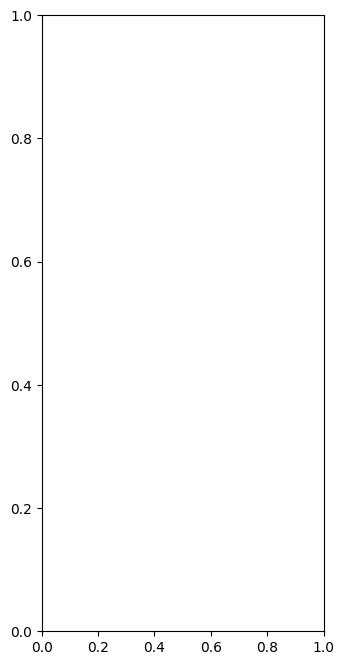

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
acc = history1.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
#model.save('C:\\Users\\Gliwork\\Desktop\\0-Rojects\\2023 Khabarovsk hackaton\\efficientnet_model.keras')
model.save(path+'\\efficientnet_40_epochs_model.keras')

In [39]:
#path = os.getcwd()
prediction_folder = path + '\\prediction'
folder = prediction_folder + '\\*'
#os.scandir
#from glob import glob
files = glob(folder, recursive = True)
#folder

In [40]:
files = glob(folder, recursive = True)
for image_path in files:
    image = tf.keras.utils.load_img(image_path)
    image = tf.image.resize(image, [img_height, img_width])
    input_arr = tf.keras.utils.img_to_array(image)
    predictions = model.predict(np.array([input_arr]))#(normalized_input_arr)
    print(image_path[image_path.rfind('\\')+1:], ' - ',np.argmax(predictions), '(',detail_names_list[np.argmax(predictions)],')')

1/1 [==============================] - 2s 2s/step
IMG_20230920_142557.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 152ms/step
IMG_20230920_142620.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 168ms/step
IMG_20230920_142632.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 154ms/step
IMG_20230920_142640.jpg  -  9 ( СВП-120.00.060 )
1/1 [==============================] - 0s 138ms/step
IMG_20230920_142656.jpg  -  9 ( СВП-120.00.060 )
